<a href="https://colab.research.google.com/github/prachuryanath/TF-Learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Processing Basics in Tensorflow
To get hands-on with NLP in TensorFlow, we're going to practice the steps we've used previously but this time with text data:

`Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)`


## What we're going to cover
Let's get specific hey?

* Downloading a text dataset
* Visualizing text data
* Converting text into numbers using tokenization
* Turning our tokenized text into an embedding
* Modelling a text dataset
  * Starting with a baseline (TF-IDF)
  * Building several deep learning text models
    * Dense, LSTM, GRU, Conv1D, Transfer learning
* Comparing the performance of each our models
* Combining our models into an ensemble
* Saving and loading a trained model
* Find the most wrong predictions


In [1]:
!nvidia-smi

Sat Jun  5 06:56:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get helper functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/prachuryanath/TF-Learning/main/extras/helper_functions.py

--2021-06-05 06:56:06--  https://raw.githubusercontent.com/prachuryanath/TF-Learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.00K  --.-KB/s    in 0s      

2021-06-05 06:56:06 (97.5 MB/s) - ‘helper_functions.py’ saved [10235/10235]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Download a text dataset

Let's start by download a text dataset. We'll be using the Real or Not? datset from Kaggle which contains text-based Tweets about natural disasters.

In [4]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2021-06-05 06:56:08--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.005s  

2021-06-05 06:56:09 (112 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



Unzipping `nlp_getting_started`.zip gives the following 3 .csv files:

* `sample_submission.csv` - an example of the file you'd submit to the Kaggle competition of your model's predictions.
* `train.csv` - training samples of real and not real diaster Tweets.
* `test.csv` - testing samples of real and not real diaster Tweets.

In [5]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [7]:
# The test data doesn't have a target (that's what we'd try to predict)
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Since we have two target values, we're dealing with a binary classification problem.

It's fairly balanced too, about 60% negative class (target = 0) and 40% positive class (target = 1).
Where,
* 1 = a real disaster Tweet
* 0 = not a real disaster Tweet

In [9]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [10]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
Morgan Silver Dollar 1880 S Gem BU DMPL Cameo Rev Blazing MS+++++ High grade! - Full read Û_ http://t.co/IU9baFDXeY http://t.co/AphqU5SvET

---

Target: 1 (real disaster)
Text:
Abe government said the missiles were not 'weapon' so JSDF could provide them to the ally when collective self defense right was exercised.

---

Target: 0 (not real disaster)
Text:
@MechaMacGyver Wow bet you got blamed for that too huh?

---

Target: 0 (not real disaster)
Text:
GOP debate drinking game. For anyone looking for a bit of fun while watching this train wreck. http://t.co/W3Rga0nkOm http://t.co/0TZsQe8ESD

---

Target: 0 (not real disaster)
Text:
@PixelJanosz @Angelheartnight I remember now.  There was a British man who survived both also.  Can't remember his name though.

---



### Split data into training and validation sets

In [11]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size =0.1,   # dedicate 10% of samples to validation set
                                                                            random_state = 42)

In [12]:
# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [13]:
# View the first 10 training sentences and their labels
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

## Converting text into numbers

**Text vectorization (tokenization)**

We'll practice tokenzation (mapping our words to numbers) first.

To tokenize our words, we'll use the helpful preprocessing layer `tf.keras.layers.experimental.preprocessing.TextVectorization`.

The TextVectorization layer takes the following parameters:

* `max_tokens` - The maximum number of words in your vocabulary (e.g. 20000 or the number of unique words in your text), includes a value for OOV (out of vocabulary) tokens.
* `standardize` - Method for standardizing text. Default is "`lower_and_strip_punctuation`" which lowers text and removes all punctuation marks.
* `split` - How to split text, default is "`whitespace`" which splits on spaces.
* `ngrams` - How many words to contain per token split, for example, `ngrams=2` splits tokens into continuous sequences of 2.
* `output_mode` - How to output tokens, can be "`int`" (integer mapping), "`binary`" (one-hot encoding), "`count`" or "`tf-idf`". See documentation for more.
* `output_sequence_length` - Length of tokenized sequence to output. For example, if `output_sequence_length=150`, all tokenized sequences will be 150 tokens long.
* `pad_to_max_tokens` - If `True` (default), the output feature axis will be padded to max_tokens even if the number of unique tokens in the vocabulary is less than max_tokens.

In [14]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long should the output sequence of tokens be?
                                    pad_to_max_tokens=True)

We've initialized a `TextVectorization` object with the default settings but let's customize it a little bit for our own use case.

In particular, let's set values for `max_tokens` and `output_sequence_length`.

For max_tokens (the number of words in the vocabulary), multiples of `10,000 (10,000, 20,000, 30,000)` or the exact number of unique words in your text `(e.g. 32,179)` are common values.

For our use case, we'll use `10,000`.

And for the `output_sequence_length` we'll use the average number of tokens per Tweet in the training set. But first, we'll need to find it.

In [15]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [16]:
# Setup text vectorization variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [17]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [18]:
# Create sample sentence and tokenize it
sample_sentence = "There's a flood in my road!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 366,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

Wonderful, it seems we've got a way to turn our text into numbers (in this case, word-level tokenization). Notice the 0's at the end of the returned tensor, this is because we set `output_sequence_length=15`, meaning no matter the size of the sequence we pass to `text_vectorizer`, it always returns a sequence with a length of 15.

In [19]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
A Marshall Plan for the United States by Dambisa Moyo via @ProSyn #oped http://t.co/GnPStnvi5G via @po_st      

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   3, 5160,  241,   10,    2,  800, 1253,   18, 5867, 5086,   49,
        4847, 4992,    1,   49]])>

In [20]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding Layer
The main parameters we're concerned about here are:

* `input_dim` - The size of the vocabulary (e.g. len(text_vectorizer.get_vocabulary()).
* `output_dim` - The size of the output embedding vector, for example, a value of 100 outputs a feature vector of size 100 for each word.
* `embeddings_initializer` - How to initialize the embeddings matrix, default is "uniform" which randomly initalizes embedding matrix with uniform distribution. This can be changed for using pre-learned embeddings.
* `input_length` - Length of sequences being passed to embedding layer.

In [21]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input
embedding

In [22]:
# Get a random sentence from training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
@YoungHeroesID LAVA BLAST dan POWER RED #PantherAttack @Mirmanda11 @evaaaSR      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.03190076, -0.00242253, -0.01273875, ..., -0.0396785 ,
         -0.0291288 ,  0.01420231],
        [-0.04265922,  0.04408724,  0.04563365, ..., -0.03252497,
         -0.01081617, -0.0185733 ],
        [-0.00458907,  0.03227844,  0.00691449, ...,  0.02078613,
         -0.04588251, -0.04110479],
        ...,
        [ 0.03200486, -0.04079875, -0.0386943 , ..., -0.04738299,
         -0.00887217,  0.00320014],
        [ 0.03200486, -0.04079875, -0.0386943 , ..., -0.04738299,
         -0.00887217,  0.00320014],
        [ 0.03200486, -0.04079875, -0.0386943 , ..., -0.04738299,
         -0.00887217,  0.00320014]]], dtype=float32)>

Each token in the sentence gets turned into a length 128 feature vector.

In [23]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([-3.19007635e-02, -2.42253393e-03, -1.27387531e-02,  9.77473333e-03,
       -2.41258033e-02,  3.52895260e-03,  3.07852514e-02,  4.89945896e-02,
       -4.30011265e-02, -3.77954729e-02,  4.21947129e-02,  9.81404632e-03,
        4.76770736e-02, -4.30630520e-03, -2.13906169e-02,  2.05234177e-02,
        4.18723710e-02,  7.24102184e-03,  4.26395275e-02,  1.35215409e-02,
       -2.39822753e-02, -2.91573536e-02,  1.09200105e-02,  2.30619349e-02,
       -1.05881579e-02,  1.78122260e-02, -3.26630101e-02, -4.85124104e-02,
        1.00157857e-02,  2.16158070e-02,  3.35370377e-03,  3.19241323e-02,
       -4.25206088e-02,  4.87149879e-03,  4.74084504e-02,  3.96238826e-02,
       -1.89575311e-02, -1.51623115e-02, -4.83855270e-02,  1.05676055e-02,
        3.03056948e-02,  5.47470897e-03, -3.57606038e-02,  2.42167152e-02,
       -3.00684702e-02, -4.57648300e-02, -1.88264381e-02, -4.04831879e-02,
        3.24849226e-02,  4.73359562e-02, -3.17935944

# Modelling a text dataset

* Model 0: Naive Bayes (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model
* Model 3: GRU model
* Model 4: Bidirectional-LSTM model
* Model 5: 1D Convolutional Neural Network
* Model 6: TensorFlow Hub Pretrained Feature Extractor
* Model 7: Same as model 6 with 10% of training data

Each experiment will go through the following steps:

1. Construct the model
2. Train the model
3. Make predictions with the model
4. Track prediction evaluation metrics for later comparison

## Model 0 : Getting a baseline

To create our baseline, we'll create a Scikit-Learn Pipeline using the TF-IDF (term frequency-inverse document frequency) formula to convert our words to numbers and then model them with the Multinomial Naive Bayes algorithm.


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([("tfidf", TfidfVectorizer()),   # convert words to numbers using tfidf
                    ("clf", MultinomialNB())        # model the text
])
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [25]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [26]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating an evaluation function for our model experiments
* Accuracy
* Precision
* Recall
* F1-score

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a
  binary classification model.
  Args :
  ----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy" : model_accuracy,
                   "precision" : model_precision,
                   "recall" : model_recall,
                   "f1" : model_f1}
  return model_results

In [28]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

## Model 1: A simple dense model

In [29]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [30]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

Looking good. Our model takes a 1-dimensional string as input (in our case, a Tweet), it then tokenizes the string using text_vectorizer and creates an embedding using embedding.

We then (optionally) pool the outputs of the embedding layer to reduce the dimensionality of the tensor we pass to the output layer.

Finally, we pass the output of the pooling layer to a dense layer with sigmoid activation (we use sigmoid since our problem is binary classification).

Before we can fit our model to the data, we've got to compile it. Since we're working with binary classification, we'll use "binary_crossentropy" as our loss function and the Adam optimizer.

In [31]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
# Get a summary of the model
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


Most of the trainable parameters are contained within the embedding layer. Recall we created an embedding of size 128 (output_dim=128) for a vocabulary of size 10,000 (input_dim=10000), hence the 1,280,000 trainable parameters.

In [32]:
# Fit the model
model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20210605-065617
Epoch 1/5
215/215 [==============================] - 7s 17ms/step - loss: 0.6104 - accuracy: 0.6887 - val_loss: 0.5328 - val_accuracy: 0.7638
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.4406 - accuracy: 0.8216 - val_loss: 0.4692 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3457 - accuracy: 0.8643 - val_loss: 0.4615 - val_accuracy: 0.7927
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2837 - accuracy: 0.8921 - val_loss: 0.4646 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2369 - accuracy: 0.9143 - val_loss: 0.4840 - val_accuracy: 0.7861


In [33]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4840 - accuracy: 0.7861


[0.4840349853038788, 0.7860892415046692]

In [34]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

array([[0.31381956],
       [0.71311873],
       [0.99789065],
       [0.10159325],
       [0.10057276],
       [0.93303365],
       [0.90955526],
       [0.9927729 ],
       [0.9641858 ],
       [0.24115662]], dtype=float32)

In [35]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)>

In [36]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.60892388451444,
 'f1': 0.7822223876855834,
 'precision': 0.7936252368304625,
 'recall': 0.7860892388451444}

In [37]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results, 
                                new_model_results=model_1_results)

Baseline accuracy: 79.27, New accuracy: 78.61, Difference: -0.66
Baseline precision: 0.81, New precision: 0.79, Difference: -0.02
Baseline recall: 0.79, New recall: 0.79, Difference: -0.01
Baseline f1: 0.79, New f1: 0.78, Difference: -0.00


### Visualizing learned embeddings

Our first model (`model_1`) contained an embedding layer (`embedding`) which learned a way of representing words as feature vectors by passing over the training data.

Hearing this for the first few times may sound confusing.

So to further help understand what a text embedding is, let's visualize the embedding our model learned.

In [38]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [39]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Get the weight matrix of embedding layer 
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


In [ ]:
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

## Recurrent Neural Networks (RNN's)

For our next series of modelling experiments we're going to be using a special kind of neural network called a **Recurrent Neural Network (RNN)**.

The premise of an RNN is simple: use information from the past to help you with the future (this is where the term recurrent comes from). In other words, take an input (X) and compute an output (y) based on all previous inputs.

This concept is especially helpful when dealing with sequences such as passages of natural language text (such as our Tweets).

Recurrent neural networks can be used for a number of sequence-based problems:

* **One to one:** one input, one output, such as image classification.
* **One to many:** one input, many outputs, such as image captioning (image input, a sequence of text as caption output).
* **Many to one:** many inputs, one outputs, such as text classification (classifying a Tweet as real diaster or not real diaster).
* **Many to many:** many inputs, many outputs, such as machine translation (translating English to Spanish) or speech to text (audio wave as input, text as output).

When you come across RNN's in the wild, you'll most likely come across variants of the following:

* `Long short-term memory cells (LSTMs)`.
* `Gated recurrent units (GRUs)`.
* `Bidirectional RNN's` (passes forward and backward along a sequence, left to right and right to left).


### Model 2 : LSTM

We're going to start with an LSTM-powered RNN.

To harness the power of the LSTM cell (LSTM cell and LSTM layer are often used interchangably) in TensorFlow, we'll use `tensorflow.keras.layers.LSTM()`.

Our model is going to take on a very similar structure to `model_1`:

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [42]:
# Create LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences =True)
x = layers.LSTM(64)(x)    # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x)    # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [43]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [45]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20210605-065637
Epoch 1/5
215/215 [==============================] - 10s 21ms/step - loss: 0.2238 - accuracy: 0.9181 - val_loss: 0.5158 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1588 - accuracy: 0.9412 - val_loss: 0.6217 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1266 - accuracy: 0.9530 - val_loss: 0.7802 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.1055 - accuracy: 0.9588 - val_loss: 0.8308 - val_accuracy: 0.7808
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0851 - accuracy: 0.9673 - val_loss: 0.9299 - val_accuracy: 0.7730


In [46]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

((762, 1), array([[1.3029672e-02],
        [8.8546664e-01],
        [9.9976724e-01],
        [2.2855008e-02],
        [3.8762722e-04],
        [9.9801648e-01],
        [8.9397603e-01],
        [9.9980873e-01],
        [9.9967003e-01],
        [3.3487469e-01]], dtype=float32))

In [47]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [48]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.29658792650919,
 'f1': 0.7709704727215051,
 'precision': 0.7745161732477092,
 'recall': 0.7729658792650919}

In [49]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 79.27, New accuracy: 77.30, Difference: -1.97
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


### Model 3 : GRU

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cell has similar features to an LSTM cell but has less parameters.

To use the GRU cell in TensorFlow, we can call the `tensorflow.keras.layers.GRU()` class.

The architecture of the GRU-powered model will follow the same structure we've been using:

`Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)`

In [50]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [51]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
gru (GRU)                    (None, 64)                37248     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_________________________________________________________________


Notice the difference in number of trainable parameters between `model_2` (LSTM) and `model_3` (GRU). The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.


In [53]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20210605-065721
Epoch 1/5
215/215 [==============================] - 6s 20ms/step - loss: 0.1628 - accuracy: 0.9364 - val_loss: 0.7004 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0858 - accuracy: 0.9673 - val_loss: 0.8205 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0722 - accuracy: 0.9711 - val_loss: 1.0441 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0579 - accuracy: 0.9750 - val_loss: 0.9668 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0517 - accuracy: 0.9771 - val_loss: 1.4435 - val_accuracy: 0.7677


In [54]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

((762, 1), array([[9.2827067e-05],
        [7.5632554e-01],
        [9.9988580e-01],
        [5.6445368e-02],
        [4.8615821e-05],
        [9.9985492e-01],
        [9.5732814e-01],
        [9.9995625e-01],
        [9.9991417e-01],
        [9.9000156e-01]], dtype=float32))

In [55]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [56]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7649853724238768,
 'precision': 0.7705418629507439,
 'recall': 0.7677165354330708}

In [57]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.76, Difference: -0.02


### Model 4 : Bidirectional RNN Model

A standard RNN will process a sequence from left to right, where as a bidirectional RNN will process the sequence from left to right and then again from right to left.

Once again, TensorFlow helps us out by providing the `tensorflow.keras.layers.Bidirectional` class. We can use the Bidirectional class to wrap our existing RNNs, instantly making them bidirectional.

In [58]:
# Build a Bidirectional RNN in TensorFlow
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [59]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [60]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


Notice the increased number of trainable parameters in model_4 (bidirectional LSTM) compared to model_2 (regular LSTM). This is due to the bidirectionality we added to our RNN.



In [61]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20210605-065741
Epoch 1/5
215/215 [==============================] - 8s 23ms/step - loss: 0.1118 - accuracy: 0.9648 - val_loss: 1.0226 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0537 - accuracy: 0.9780 - val_loss: 1.1940 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0519 - accuracy: 0.9784 - val_loss: 1.1585 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0419 - accuracy: 0.9801 - val_loss: 1.2296 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0391 - accuracy: 0.9804 - val_loss: 1.5183 - val_accuracy: 0.7690


In [62]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

array([[1.3188689e-03],
       [6.9924265e-01],
       [9.9998748e-01],
       [1.0427738e-01],
       [9.1959791e-06],
       [9.9937916e-01],
       [6.5241265e-01],
       [9.9998748e-01],
       [9.9998426e-01],
       [9.9553156e-01]], dtype=float32)

In [63]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [64]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.9028871391076,
 'f1': 0.7670626202962317,
 'precision': 0.7703609632684677,
 'recall': 0.7690288713910761}

In [65]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 79.27, New accuracy: 76.90, Difference: -2.36
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Covolutional Neural Networks for Text

The main difference between using CNNs for images and sequences is the shape of the data. Images come in 2-dimensions (height x width) where as sequences are often 1-dimensional (a string of text).

So to use CNNs with sequences, we use a 1-dimensional convolution instead of a 2-dimensional convolution.

A typical CNN architecture for sequences will look like the following:

`Inputs (text) -> Tokenization -> Embedding -> Layers -> Outputs (class probabilities)`

The difference again is in the layers component. Instead of using an LSTM or GRU cell, we're going to use a `tensorflow.keras.layers.Conv1D()` layer followed by a `tensorflow.keras.layers.GlobablMaxPool1D()` layer.

### Model 5 : Conv1D

Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a temporal convolution) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [66]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

The embedding has an output shape dimension of the parameters we set it to (`input_length=15` and `output_dim=128`).

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

In [67]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.01374843,  0.02129278,  0.02984431, ..., -0.07407638,
           0.0354228 ,  0.0142892 ],
         [-0.01900367,  0.09623166,  0.00663293, ..., -0.04154462,
           0.07931519, -0.04664357],
         [-0.05866097, -0.01341076,  0.0341325 , ..., -0.01316493,
           0.02184204, -0.00182547],
         ...,
         [-0.00577683, -0.01886478, -0.01328105, ..., -0.04913909,
           0.00375702, -0.00399138],
         [-0.00577683, -0.01886478, -0.01328105, ..., -0.04913909,
           0.00375702, -0.00399138],
         [-0.00577683, -0.01886478, -0.01328105, ..., -0.04913909,
           0.00375702, -0.00399138]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.08912495, 0.        , 0.04773278, 0.        , 0.        ,
          0.04623758, 0.        , 0.09865971, 0.07878119, 0.        ,
          0.        , 0.06558101, 0.00714454, 0.01820039, 0.02504179,
          0.        , 0.

In [68]:
# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 32)            20512     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,300,545
Trainable params: 1,300,545
Non-trainable params: 0
__________________________________________

In [69]:
# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20210605-065830
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.1311 - accuracy: 0.9585 - val_loss: 0.8628 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 1.0096 - val_accuracy: 0.7677
Epoch 3/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0628 - accuracy: 0.9752 - val_loss: 1.0823 - val_accuracy: 0.7598
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.0542 - accuracy: 0.9791 - val_loss: 1.1472 - val_accuracy: 0.7598
Epoch 5/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0498 - accuracy: 0.9794 - val_loss: 1.2126 - val_accuracy: 0.7598


In [70]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

array([[1.2933905e-01],
       [7.4059081e-01],
       [9.9996722e-01],
       [7.2094992e-02],
       [4.9123884e-08],
       [9.9334782e-01],
       [9.8978406e-01],
       [9.9998820e-01],
       [9.9999988e-01],
       [8.8409293e-01]], dtype=float32)

In [71]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [72]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 75.98425196850394,
 'f1': 0.758578322737536,
 'precision': 0.7598710707718088,
 'recall': 0.7598425196850394}

In [73]:
# Compare model_5 results to baseline 
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 79.27, New accuracy: 75.98, Difference: -3.28
Baseline precision: 0.81, New precision: 0.76, Difference: -0.05
Baseline recall: 0.79, New recall: 0.76, Difference: -0.03
Baseline f1: 0.79, New f1: 0.76, Difference: -0.03


## Using Pretrained Embeddings (transfer learning for NLP )

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

### Model 6 : TensorFlow Hub Pretrained Sentence Encoder

The main difference between the embedding layer we created and the **Universal Sentence Encoder** is that rather than create a word-level embedding, the **Universal Sentence Encoder**, as you might've guessed, creates a whole sentence-level embedding.

*Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.*

We can load in a TensorFlow Hub module using the `hub.load()` method and passing it the target URL of the module we'd like to use, in our case, it's `"https://tfhub.dev/google/universal-sentence-encoder/4"`.

In [74]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.00227923  0.02503782  0.05165793 -0.02049924  0.06524664  0.07871991
  0.04292819  0.05375134  0.02137922 -0.01271617  0.01633732 -0.0236556
 -0.00251637  0.08856936  0.04738833 -0.03504737  0.01855711 -0.01724731
 -0.0171118  -0.02748966 -0.0463478   0.03816369  0.06219235  0.01337105
 -0.02875983 -0.05794404  0.03516345 -0.00216923 -0.04345246 -0.02009531
 -0.06199861  0.03515631 -0.0169575  -0.0254854  -0.02920206 -0.0685383
  0.02810755  0.03589788  0.01183301 -0.07927105  0.030587   -0.02572455
 -0.03626588  0.04522885 -0.10527454 -0.00228848 -0.01724683  0.00489267
 -0.01167761  0.03022392], shape=(50,), dtype=float32)


In [75]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the hub.KerasLayer class.

In [76]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [77]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

# Compile model
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [78]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20210605-071229
Epoch 1/5
215/215 [==============================] - 7s 23ms/step - loss: 0.5029 - accuracy: 0.7844 - val_loss: 0.4496 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4148 - accuracy: 0.8174 - val_loss: 0.4360 - val_accuracy: 0.8110
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4011 - accuracy: 0.8228 - val_loss: 0.4374 - val_accuracy: 0.8071
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3937 - accuracy: 0.8266 - val_loss: 0.4301 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.3869 - accuracy: 0.8289 - val_loss: 0.4265 - val_accuracy: 0.8150


In [79]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.19880572],
       [0.78401333],
       [0.9865013 ],
       [0.22457188],
       [0.7512788 ],
       [0.7497252 ],
       [0.98350656],
       [0.9796083 ],
       [0.94336957],
       [0.09099196]], dtype=float32)

In [80]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [81]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8138139523860313,
 'precision': 0.8161852632862286,
 'recall': 0.8149606299212598}

In [82]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline precision: 0.81, New precision: 0.82, Difference: 0.01
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03


### Model 7 : Tensorflow Hub Pretrained Sentence Encoder 10% of the training data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [83]:
### NOTE: Making splits like this will lead to data leakage ###
### (some of the training examples in the validation set) ###

### WRONG WAY TO MAKE SPLITS (train_df_shuffled has already been split) ### 

# # Create subsets of 10% of the training data
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

In [85]:
import numpy as np
# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)
# Check length of 10 percent datasets
print(f"Total training examples: {len(train_sentences)}")
print(f"Length of 10% training examples: {len(train_sentences_10_percent)}")

Total training examples: 6851
Length of 10% training examples: 686


In [86]:
# Check the number of targets in our subset of data 
# (this should be close to the distribution of labels in the original train_labels)
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

In [87]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [88]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_sentence_encoder/20210605-071804
Epoch 1/5
22/22 [==============================] - 4s 113ms/step - loss: 0.6717 - accuracy: 0.6356 - val_loss: 0.6494 - val_accuracy: 0.7507
Epoch 2/5
22/22 [==============================] - 0s 19ms/step - loss: 0.6035 - accuracy: 0.7974 - val_loss: 0.5931 - val_accuracy: 0.7520
Epoch 3/5
22/22 [==============================] - 0s 19ms/step - loss: 0.5299 - accuracy: 0.8265 - val_loss: 0.5407 - val_accuracy: 0.7769
Epoch 4/5
22/22 [==============================] - 0s 19ms/step - loss: 0.4668 - accuracy: 0.8280 - val_loss: 0.5120 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 18ms/step - loss: 0.4203 - accuracy: 0.8309 - val_loss: 0.4891 - val_accuracy: 0.7717


In [89]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)

# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [90]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.16535433070865,
 'f1': 0.7691811868378113,
 'precision': 0.7741380916586217,
 'recall': 0.7716535433070866}

In [91]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 77.17, Difference: -2.10
Baseline precision: 0.81, New precision: 0.77, Difference: -0.04
Baseline recall: 0.79, New recall: 0.77, Difference: -0.02
Baseline f1: 0.79, New f1: 0.77, Difference: -0.02


## Comaring the performance of each of our models

The important thing to note is that for all of our modelling experiments we used the same training data (except for model_7 where we used 10% of the training data).

In [93]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.793625,0.786089,0.782222
lstm,77.296588,0.774516,0.772966,0.770970
gru,76.771654,0.770542,0.767717,0.764985
bidirectional,76.902887,0.770361,0.769029,0.767063
conv1d,75.984252,0.759871,0.759843,0.758578
tf_hub_sentence_encoder,81.496063,0.816185,0.814961,0.813814
tf_hub_10_percent_data,77.165354,0.774138,0.771654,0.769181


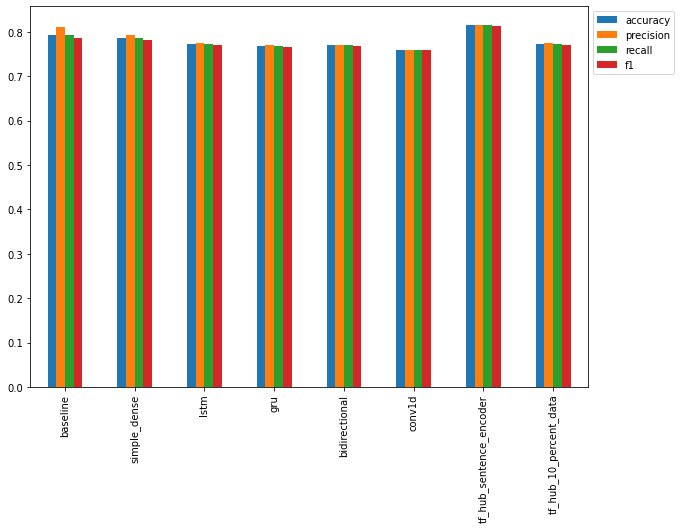

In [94]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

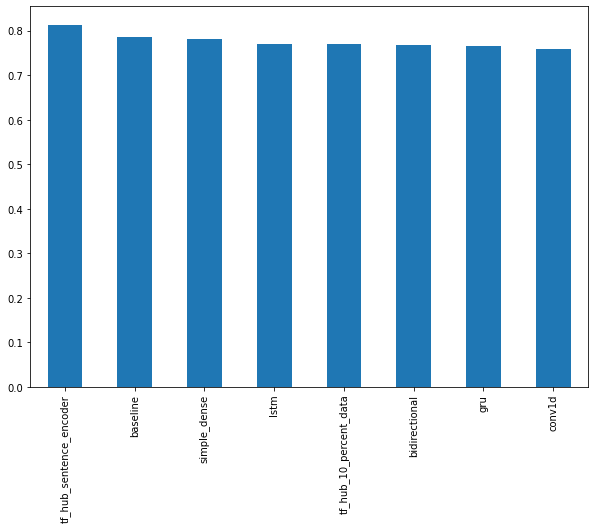

In [95]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

## Combining our models (model ensembling/stacking)

Many production systems use an **ensemble** (multiple different models combined) of models to make a prediction.

The idea behind model stacking is that if several uncorrelated models agree on a prediction, then the prediction must be more robust than a prediction made by a singular model.

The keyword in the sentence above is uncorrelated, which is another way of saying, different types of models. For example, in our case, we might combine our baseline, our bidirectional model and our `TensorFlow Hub USE model`.

Think of it as trying to decide where to eat with your friends. If you all have similar tastes, you'll probably all pick the same restaurant. But if you've all got different tastes and still end up picking the same restaurant, the restaurant must be good.

Since we're working with a classification problem, there are a few of ways we can combine our models:

1. **Averaging** - *Take the output prediction probabilities of each model for each sample, combine them and then average them.*
2. **Majority vote (mode)** - *Make class predictions with each of your models on all samples, the predicted class is the one in majority. For example, if three different models predict [1, 0, 1] respectively, the majority class is 1, therefore, that would be the predicted label.*
3. **Model stacking** - *Take the outputs of each of your chosen models and use them as inputs to another model.*

We're going to combine our baseline model (`model_0`), LSTM model (`model_2`) and our USE model trained on the full training data (`model_6`) by averaging the combined prediction probabilities of each.

In [96]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
       1., 0., 1.], dtype=float32)>

In [97]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 79.52755905511812,
 'f1': 0.7949420796084701,
 'precision': 0.7950062580205643,
 'recall': 0.7952755905511811}

In [98]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [99]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

all_model_results

,accuracy,precision,recall,f1
baseline,0.792651,0.811139,0.792651,0.786219
simple_dense,0.786089,0.793625,0.786089,0.782222
lstm,0.772966,0.774516,0.772966,0.770970
gru,0.767717,0.770542,0.767717,0.764985
bidirectional,0.769029,0.770361,0.769029,0.767063
conv1d,0.759843,0.759871,0.759843,0.758578
tf_hub_sentence_encoder,0.814961,0.816185,0.814961,0.813814
tf_hub_10_percent_data,0.771654,0.774138,0.771654,0.769181
ensemble_results,0.795276,0.795006,0.795276,0.794942


In [100]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

If you save a model as a HDF5, when loading it back in, you need to let TensorFlow know about any custom objects you've used (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [101]:
# Load model with custom Hub Layer (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5", 
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [102]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4265 - accuracy: 0.8150


[0.4265137016773224, 0.8149606585502625]

In [103]:
# Save TF Hub Sentence Encoder model to SavedModel format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


In [104]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [105]:
# Evaluate loaded SavedModel format
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 9ms/step - loss: 0.4265 - accuracy: 0.8150


[0.4265137016773224, 0.8149606585502625]

## Finding the most wrong examples

One of the best ways to inspect your data is to sort your model's predictions and find the samples it got most wrong, meaning, what predictions had a high prediction probability but turned out to be wrong.

To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

In [110]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.198806
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.784013
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.986501
3,@camilacabello97 Internally and externally scr...,1,0.0,0.224572
4,Radiation emergency #preparedness starts with ...,1,1.0,0.751279


Oh yeah! Now let's find our model's wrong predictions (where target != pred) and sort them by their prediction probability (the pred_prob column).

In [111]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.925954
759,FedEx will no longer transport bioterror patho...,0,1.0,0.895226
628,@noah_anyname That's where the concentration c...,0,1.0,0.870703
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.858752
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.858276
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.848201
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.846620
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.842779
695,A look at state actions a year after Ferguson'...,0,1.0,0.829440
144,The Sound of Arson,0,1.0,0.826037


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our most_wrong DataFrame will show us false positives.

A reminder:

* `0 = Not a real diaster Tweet`
* `1 = Real diaster Tweet`

In [112]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.9259544014930725
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1, Prob: 0.8952259421348572
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1, Prob: 0.8707029223442078
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1, Prob: 0.8587522506713867
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1, Prob: 0.8582755923271179
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

Target: 0, Pred: 1, Prob: 0.8482012748718262
Text:
[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES WITH MAGNE-TRACTION INSTRUCTIONS http://t.co/xEZBs3sq0y http://t.co/C2x0QoKGlY

----

Target: 0, Pred: 1, Prob

In [113]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 1, Pred: 0, Prob: 0.07047490030527115
Text:
@DavidVonderhaar At least you were sincere ??

----

Target: 1, Pred: 0, Prob: 0.06936823576688766
Text:
'The way you move is like a full on rainstorm and I'm a house of cards'

----

Target: 1, Pred: 0, Prob: 0.06683379411697388
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target: 1, Pred: 0, Prob: 0.05412893742322922
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target: 1, Pred: 0, Prob: 0.05357828363776207
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target: 1, Pred: 0, Prob: 0.04913429543375969
Text:
I get to smoke my shit in peace

----

Target: 1, Pred: 0, Prob: 0.049077462404966354
Text:
@SoonerMagic_ I mean I'm a fan but I don't need a gi

### Making predictions on the test dataset

Alright we've seen how our model's perform on the validation set.

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.



In [115]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample])) # has to be list
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("----\n")

Pred: 0, Prob: 0.47517892718315125
Text:
The Dones felt grief bordering on devastation at losing connection with God through their church communities. Packard http://t.co/r2pQQPfqCt

----

Pred: 0, Prob: 0.054715074598789215
Text:
@iam_destruction Okay.. I'll put my tail in first.. -He moved to slip it in slowly.-

----

Pred: 1, Prob: 0.8383961319923401
Text:
Family mourns drowning of 'superhero' toddler with rare epilepsy: Bradley Diebold suffered hundreds of epilept... http://t.co/aSAn4yGd48

----

Pred: 0, Prob: 0.06576615571975708
Text:
@LadyShaxx That is freaking awesome!

----

Pred: 0, Prob: 0.11035394668579102
Text:
YE SBUJDJSJS YES YES I XUSKAK I SCREAMED PROTECT MY OTHER SON PROTECT UR BOYFRIEND YES  https://t.co/kDqtqGK5pI

----

Pred: 0, Prob: 0.21528947353363037
Text:
@bottleowhite i had to cover my eyes with the mudslide #toopainful

----

Pred: 0, Prob: 0.2894623577594757
Text:
#hot  Funtenna: hijacking computers to send data as sound waves [Black Hat 2015] http://t.co/

### Predicting on Tweets from the wild

In [128]:
# Turn Tweet into string
prachurya_tweet = "Life is like a wildfire. It burns slowly "

In [129]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [130]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=prachurya_tweet)

Pred: 1.0 (real disaster) Prob: 0.6579557657241821
Text:
Life is like a wildfire. It burns slowly 


In [131]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [133]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9702665209770203
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [134]:
# Predict on diaster Tweet 2
predict_on_sentence(model=model_6, 
                    sentence=beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9808762669563293
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


## The speed/score tradeoff

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

In [135]:
# Calculate the time of predictions
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  
  Args:
  ----
  model = a trained model
  sample = a list of samples

  Returns:
  ----
  total_time = total elapsed time for model to make predictions on samples
  time_per_pred = time in seconds per single sample
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long predictions took to make
  time_per_pred = total_time/len(val_sentences) # find prediction time per sample
  return total_time, time_per_pred

In [136]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.2236374150006668, 0.0002934874212607176)

In [137]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.019145039999784785, 2.5124724409166386e-05)

It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.



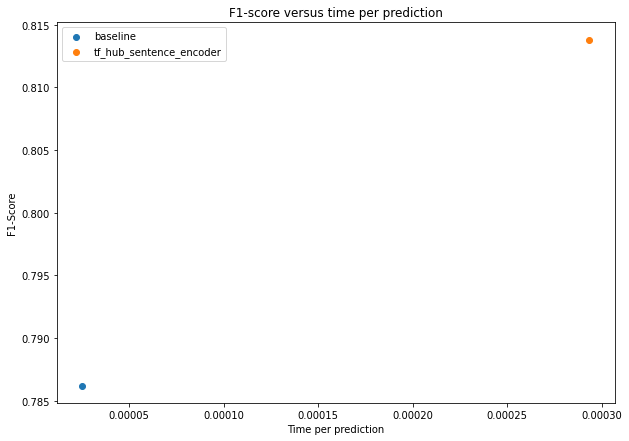

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

Of course, the ideal position for each of these dots is to be in the top left of the plot (low time per prediction, high F1-score).

In our case, there's a clear tradeoff for time per prediction and performance. Our best performing model takes an order of magnitude longer per prediction but only results in a few F1-score point increase.

